# Tugas Praktikum Minggu 9: Audio Classification
### Nicholas Juan Kalvin P. | 162012133068
<hr>



### Informasi Dataset
<p>Audio classification adalah teknik dimana berbagai macam bentukan suara dibedakan berdasarkan karakter-karakter uniknya. Pada praktikum audio classification ini, digunakan dataset terbuka <i>Free Spoken Digit Dataset (FSDD)</i> yang adalah dataset audio/pembicaraan yang simpel yang terdiri dari rekaman penyebutan angka pada 8kHz dengan ekstensi file `wav`. Jumlah rekaman terdiri dari 3000 rekaman yang diucapkan oleh 6 orang berbeda, dengan angka yang diucapkan adalah angka 0 sampai 9.</p>

### Tujuan Akhir Praktikum
<p>Selain sebagai pemenuhan nilai mata kuliah <i>Data Mining</i>, dimana fungsi dari model yang akan diciptakan dapat mengklasifikasikan angka yang diucapkan seperti yang terdapat di dataset.

<hr>

In [1]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
import random
from tqdm import tqdm

# Loading Data

Karena banyaknya file yang harus di proses, data yang di masukkan ke dalam `runtime` bukanlah semuanya sekaligus karena akan menghabiskan banyak sumber daya. Metode memasukkan file yang dipilih adalah dengan mencatatat semua nama file, label, dan path dari file ke dalam dataframe. Saat program membaca konten dataframe, pada saat itulah file audio dibaca.

In [2]:
data_path = "./nicolas/recordings"
fixedname = ['george', 'jackson', 'lucas','nicolas', 'theo', 'yweweler']
sets = []
name = []
numbers = []

for s in tqdm(range(0, 10)):
    for n in fixedname:
        for i in range(0, 50):
            sets.append(s)
            name.append(n)
            numbers.append(i)

list_files = pd.DataFrame(data={'number': sets, 'name': name, 'set': numbers})
list_files['path'] = data_path + '/' + list_files['number'].astype(str) +'_' + list_files['name'] + '_' + list_files['set'].astype(str) + '.wav'

100%|██████████| 10/10 [00:00<00:00, 10022.23it/s]


In [3]:
list_files.head(20)


,number,name,set,path
0,0,george,0,./nicolas/recordings/0_george_0.wav
1,0,george,1,./nicolas/recordings/0_george_1.wav
2,0,george,2,./nicolas/recordings/0_george_2.wav
3,0,george,3,./nicolas/recordings/0_george_3.wav
4,0,george,4,./nicolas/recordings/0_george_4.wav
5,0,george,5,./nicolas/recordings/0_george_5.wav
6,0,george,6,./nicolas/recordings/0_george_6.wav
7,0,george,7,./nicolas/recordings/0_george_7.wav
8,0,george,8,./nicolas/recordings/0_george_8.wav
9,0,george,9,./nicolas/recordings/0_george_9.wav


In [4]:
print('Bentuk dataframe:', list_files.shape)
print('Kolom pada dataframe:', list_files.columns)

list_files.groupby('name').sum(numeric_only=True)

Bentuk dataframe: (3000, 4)
Kolom pada dataframe: Index(['number', 'name', 'set', 'path'], dtype='object')


,number,set
name,,
george,2250,12250
jackson,2250,12250
lucas,2250,12250
nicolas,2250,12250
theo,2250,12250
yweweler,2250,12250


Dari tampilan bentukan data diatas terlihat bahwa jumlah pembagian data diantara nama-nama dan jumlah set adalah seimbang. Tidak diperlukan balancing. Data juga diasumsikan tidak mengandung null value atau duplikasi

<hr>

# EDA and Visualization

## Random sampling

In [5]:
def visulize_random_sample(dataframe):
  #to hear the audio sample
  filerandom = dataframe.sample(ignore_index=True, axis=0)
  filename = list(filerandom['path'])[0]
  sample_sound, sample_rate = librosa.load(filename)
  print(filerandom)
  return sample_sound, sample_rate

sample_sound, sample_rate = visulize_random_sample(list_files)
ipd.Audio(sample_sound, rate=sample_rate)

   number   name  set                                 path
0       8  lucas   44  ./nicolas/recordings/8_lucas_44.wav


### Waveform

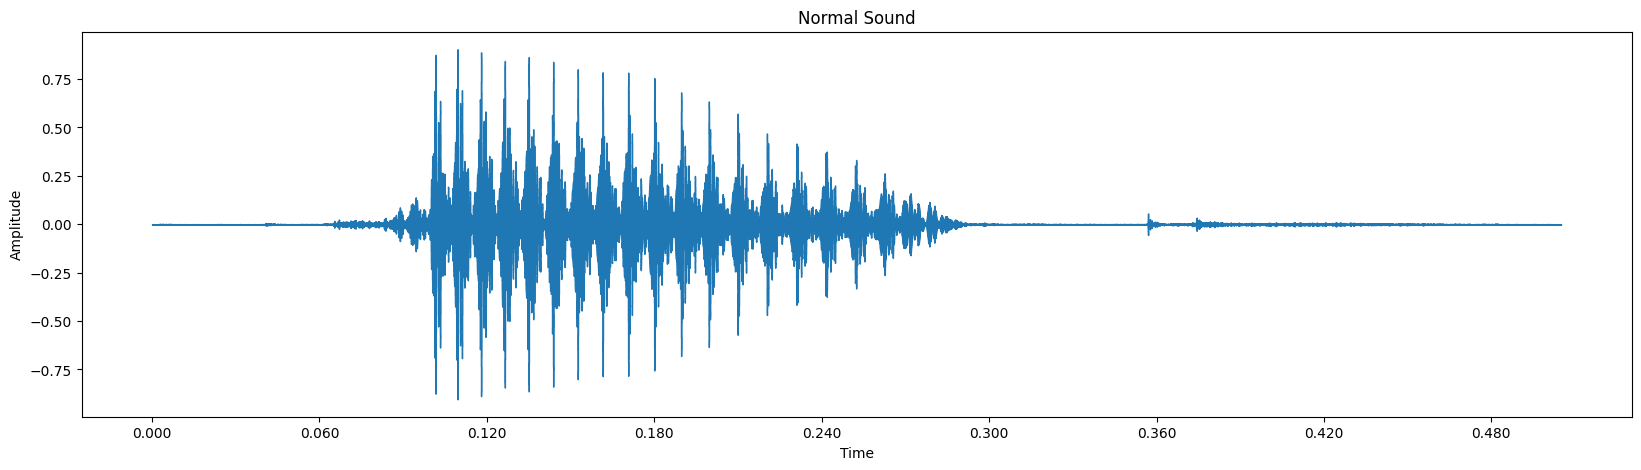

In [6]:
#librosa.display.waveshow(data, sr=sampling_rate)

plt.figure(figsize=(20,5))
librosa.display.waveshow(sample_sound, sr = sample_rate)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Spectrum

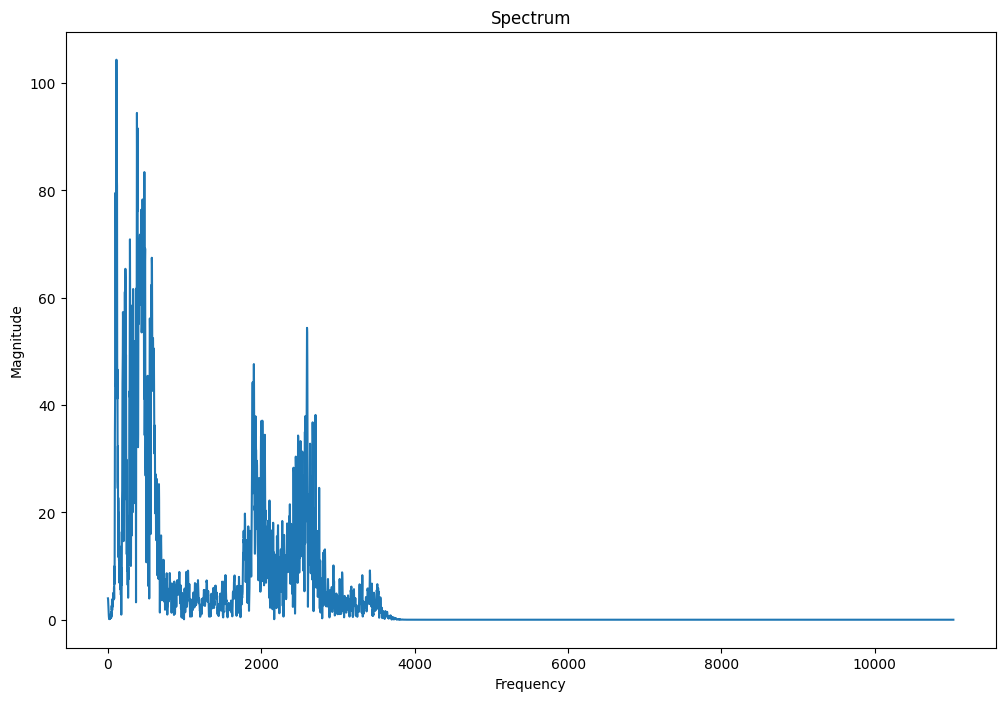

In [7]:
fft_normal = np.fft.fft(sample_sound) #fast Fourier transform
magnitude_normal = np.abs(fft_normal)
freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
half_freq = freq_normal[:int(len(freq_normal)/2)]
half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

plt.figure(figsize=(12,8))
plt.plot(half_freq,half_magnitude)
plt.title("Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Spectogram

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

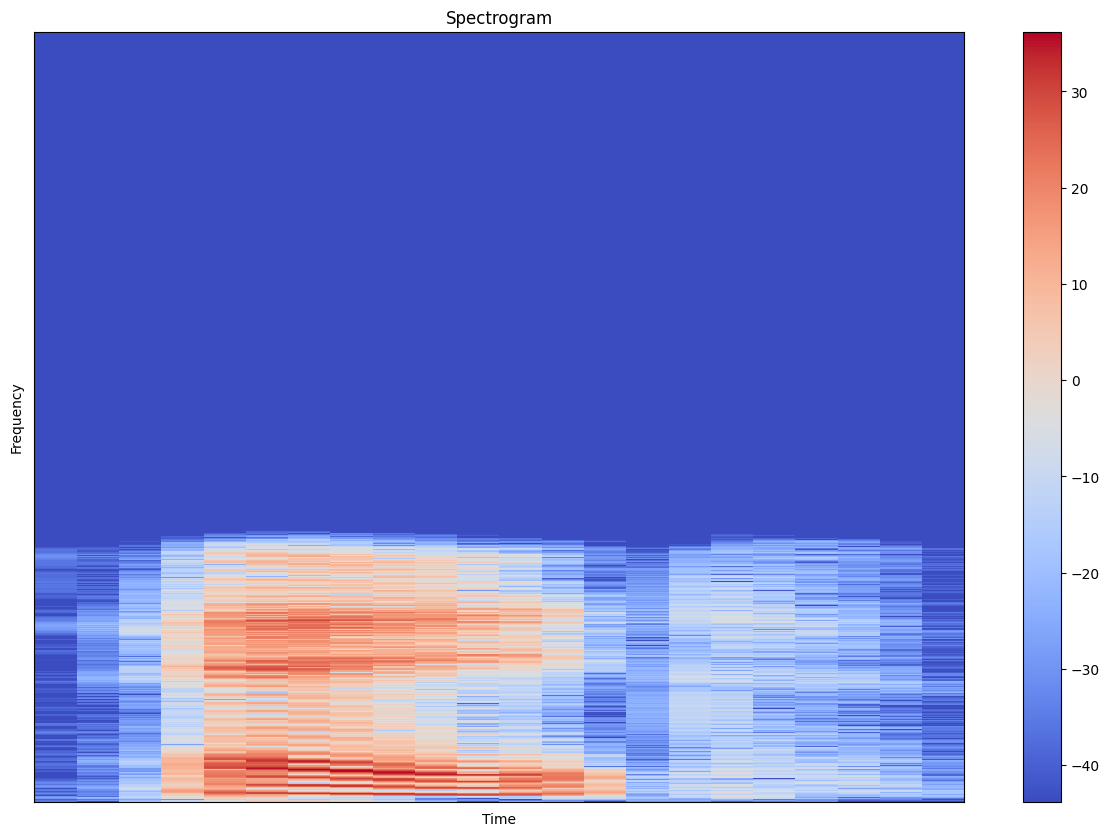

In [8]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft_normal = librosa.stft(sample_sound, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft_normal)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# display spectrogram
plt.figure(figsize=(15,10))
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
#plt.set_cmap("YlOrBr")
plt.title("Spectrogram")

### MFCCs

C:\Users\nicho\AppData\Local\Temp\ipykernel_168\682057517.py:3: FutureWarning: Pass y=[0.00022207 0.00030377 0.00029986 ... 0.000522   0.00029313 0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(sample_sound, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)


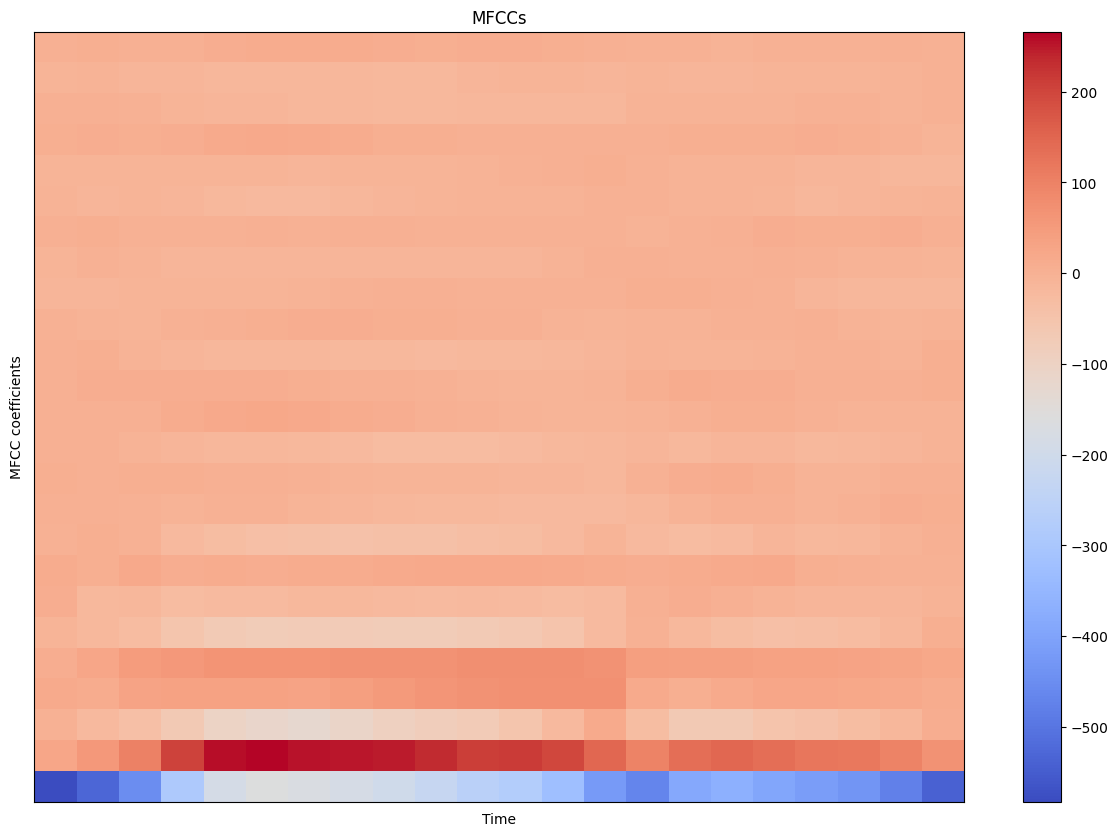

In [9]:
# MFCCs
# extract 25 MFCCs
MFCCs = librosa.feature.mfcc(sample_sound, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)

# display MFCCs
plt.figure(figsize=(15,10))
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
#plt.set_cmap("YlOrBr")
plt.title("MFCCs")

# show plots
plt.show()

Visualisasi diatas adalah visualisasi yang membantu dalam menentukan langkah preprosesing selanjutnya, atau untuk menentukan apakah data audio butuh di bersihkan secara mendalam.

<hr>

# *Encoding*

Encoding adalah proses transformasi data menjadi bentuk lain yang memberikan keuntungan dan efisiensi pada saat file dijalankan, ditransmisi atau di proses. Pada praktikum ini, encoding dilakukan untuk mengunbah bentuk file audio yang asli yang berupa matriks satu dimensi dengan tipe objek `float32` menjadi bentuk lain. Encoding juga dapat berupa data hasil ekstraksi fitur.

In [10]:
def load_file_data (paths, duration=10, sr=22050, n_mfcc=13):
    input_length=sr*duration
    data = []
    for sound_file in tqdm(paths):
        try:
            X, sr = librosa.load( sound_file, sr=sr, duration=duration)
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(X, input_length)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=n_mfcc).T,axis=0)
        except Exception as e:
            print("Error encountered while parsing file: ", e)        
            return
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

Fungsi diatas adalah `routine` yang mempermudah preprosesing the menggabungkan fungsi pembacaan file dan transformasi file menjadi MFCC secara sekaligus. 

In [11]:
sounds = load_file_data (list_files['path'], duration=3, n_mfcc=39)
labels = list_files['number']


  0%|          | 0/3000 [00:00<?, ?it/s]C:\Users\nicho\AppData\Local\Temp\ipykernel_168\1727883716.py:10: FutureWarning: Pass size=66150 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(X, input_length)
100%|██████████| 3000/3000 [01:29<00:00, 33.53it/s]


In [70]:
from sklearn.model_selection import train_test_split

CLASSES = ['0', '1','2','3','4','5','6','7','8','9']
NB_CLASSES=len(CLASSES)

X = np.asarray(sounds).astype(np.float32)
y = np.asarray(list_files['number'])
# split data into Train, Validation and Test

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, shuffle=True)

y_train = np.array(tf.keras.utils.to_categorical(y_train, num_classes=NB_CLASSES))
# y_test = np.array(tf.keras.utils.to_categorical(y_test, num_classes=NB_CLASSES))
y_val = np.array(tf.keras.utils.to_categorical(y_val, num_classes=NB_CLASSES))

In [71]:
print('Length of x_train:', len(x_train))
print('Length of y_train:', len(y_train))
print('Length of x_test:', len(x_test))
print('Length of y_test:', len(y_test))
print('Length of x_val:', len(x_val))
print('Length of y_val:', len(y_val))
print()
print('Shape of x_train:', (x_train.shape))
print('Shape of y_train:', (y_train.shape))
print()
print('Shape of x_test:', (x_test.shape))
print('Shape of y_test:', (y_test.shape))
print()
print('Shape of x_val:', (x_val.shape))
print('Shape of y_val:', (y_val.shape))

Length of x_train: 1920
Length of y_train: 1920
Length of x_test: 600
Length of y_test: 600
Length of x_val: 480
Length of y_val: 480

Shape of x_train: (1920, 39, 1)
Shape of y_train: (1920, 10)

Shape of x_test: (600, 39, 1)
Shape of y_test: (600,)

Shape of x_val: (480, 39, 1)
Shape of y_val: (480, 10)


In [72]:
y_test

array([8, 2, 2, 8, 4, 4, 3, 1, 0, 2, 2, 8, 6, 0, 5, 6, 2, 4, 5, 5, 6, 3,
       7, 8, 0, 2, 3, 5, 6, 9, 5, 9, 7, 2, 3, 8, 6, 9, 6, 4, 9, 1, 0, 0,
       4, 3, 1, 0, 1, 6, 8, 5, 5, 5, 6, 4, 2, 4, 2, 1, 9, 8, 8, 8, 5, 7,
       6, 8, 4, 9, 9, 8, 7, 6, 8, 1, 5, 6, 0, 3, 4, 6, 9, 9, 7, 7, 3, 1,
       5, 9, 4, 5, 6, 9, 6, 4, 7, 6, 8, 6, 5, 8, 0, 7, 2, 2, 6, 5, 1, 6,
       4, 3, 9, 3, 3, 1, 0, 5, 4, 0, 3, 2, 5, 3, 9, 5, 3, 1, 9, 8, 4, 9,
       7, 0, 0, 4, 4, 6, 0, 6, 4, 4, 7, 2, 0, 5, 6, 5, 0, 1, 2, 9, 4, 0,
       5, 0, 0, 8, 2, 7, 7, 1, 5, 1, 3, 5, 7, 4, 3, 5, 0, 8, 2, 7, 8, 2,
       5, 9, 5, 6, 5, 8, 2, 8, 1, 8, 9, 4, 7, 2, 2, 7, 2, 2, 0, 8, 4, 6,
       2, 1, 8, 9, 2, 5, 6, 1, 0, 3, 1, 8, 4, 5, 9, 4, 4, 4, 1, 7, 0, 2,
       0, 5, 4, 3, 2, 6, 8, 4, 9, 7, 4, 1, 6, 4, 3, 8, 3, 3, 3, 4, 2, 9,
       2, 6, 9, 4, 8, 7, 3, 3, 5, 0, 4, 0, 6, 4, 0, 3, 6, 2, 0, 1, 1, 4,
       6, 2, 2, 0, 9, 8, 9, 0, 0, 3, 1, 0, 8, 8, 7, 5, 3, 2, 4, 6, 0, 3,
       8, 1, 6, 1, 5, 3, 1, 4, 3, 4, 9, 8, 4, 8, 4,

<hr>

# Model Building

Model adalah bagian inti dari pembuatan <i>Machine Learning</i>. Dalam pembuatan model, dibutuhkan wawasan dan pengetahuan
yang mendalam agar dapat menentukan pilihan <i>layer</i> yang benar agar data dapat di <i>train</i> dengan optimal. <br><br>
Pada model ini, berdasarkan referensi berikut:
<ul>
    <li> [1] <a href="https://github.com/eonu/sequentia"> Edwin Onuonga. <b>"sequentia: A machine learning interface for isolated temporal sequence classification algorithms in Python"</b> (2019) </a></li>
    <li>[2] <a href="https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/"> David Ha. <b>"Generating Large Images from Latent Vectors"</b> <code>blog.otoro.net</code> (2016) </a></li>
    <li>[3] <a href="http://people.irisa.fr/Romain.Tavenard/?page=2"> Romain Tavenard. <b>"Machine Learning & Time Series"</b> (2016) </a></li>
    <li>[4] <a href="https://pdfs.semanticscholar.org/05a2/0cde15e172fc82f32774dd0cf4fe5827cad2.pdf"> Stan Salvador, and Philip Chan. <b>"FastDTW: Toward accurate dynamic time warping in linear time and space"</b> Intelligent Data Analysis 11.5 (2007), 561-580. </a></li>
    <li>[5] <a href="https://arxiv.org/pdf/1412.6980.pdf"> Diederik P. Kingma, and Jimmy Lei Ba. <b>"Adam: A Method For Stochastic Optimization"</b> Proceedings of the 3rd International Conference on Learning Representations (ICLR 2015). </a></li>
    <li>[6]  <a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html"> Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le. <b>"SpecAugment: A New Data Augmentation Method for Automatic Speech Recognition"</b> Google Brain (2019). </a></li>
</ul>

Dihipotesiskan bahwa model yang mendekati sempurna (optimal) pernah dicapai menggunakan metode klasifikasi
<i>Dynamic Time Wrapping K-NN</i>, dan <i>Bidirectional RNN </i> dengan <i>LSTM</i>
oleh karena itu,digunakan model Bidirectional LSTM RNN.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [99]:
model = Sequential([
    layers.Input(shape=(39,1)),
    layers.Bidirectional(
        LSTM(50,
             dropout=0.05,
             recurrent_dropout=0.30,
             return_sequences=True)),

    layers.Flatten(),
    layers.Dense(100,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.002), metrics=['acc'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_28 (Bidirecti  (None, 39, 100)          20800     
 onal)                                                           
                                                                 
 flatten_28 (Flatten)        (None, 3900)              0         
                                                                 
 dense_66 (Dense)            (None, 100)               390100    
                                                                 
 dropout_32 (Dropout)        (None, 100)               0         
                                                                 
 dense_67 (Dense)            (None, 10)                1010      
                                                                 
Total params: 411,910
Trainable params: 411,910
Non-trainable params: 0
_______________________________________________

<hr>

# Model Fitting
Proses fitting adalah proses dimana data-data yang telah diolah dimasukkan ke dalam model.
Dengan parameter yang tepat, model yang tercipta mungkin saja memiliki akurasi, kecepatan dan tingkat efisiensi yang tinggi.
Dibutuhkan pengetahuan lebih untuk dapat menentukan parameter yang tepat untuk trainin.

In [75]:
history=model.fit(x_train, y_train, 
                  batch_size=64,
                  epochs=50,
                  validation_data=(x_val, y_val))

Epoch 1/32
30/30 [==============================] - 8s 175ms/step - loss: 2.0639 - acc: 0.2667 - val_loss: 1.5290 - val_acc: 0.5042

<AxesSubplot: >

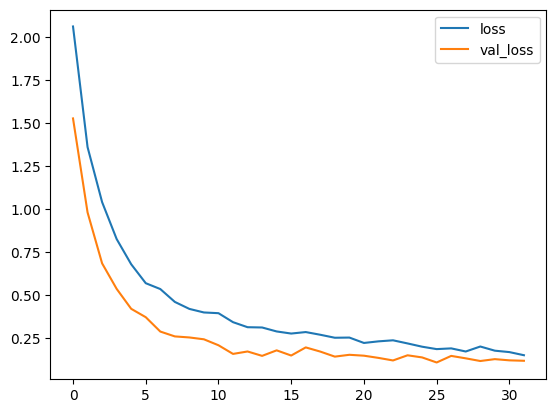

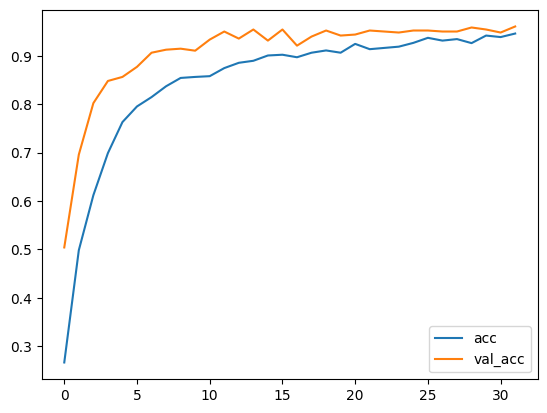

In [76]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
losses[['acc','val_acc']].plot()

# Prediction

In [97]:
# prediction class
y_pred = np.asarray(model.predict(x_test, batch_size=64))
y_pred = np.argmax(y_pred,axis=1)
scores = model.evaluate(x_test, y_test)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

10/10 [==============================] - 0s 44ms/step


ValueError: in user code:

    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible


In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

clf_report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)




# Saving and loading model

In [80]:
model.save('number_guesser_96.hdf5') #HDF5 file (Hierarchical Data Format 5)


In [ ]:
from keras.models import load_model
model = load_model('number_guesser.hdf5')
